<a href="https://colab.research.google.com/github/Gaurs86/ML-Assignments/blob/main/Denoising_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np

#MNIST Dataset with Random Patch Noise

In [ ]:
class NoisyMNIST(Dataset):
    def __init__(self, train=True):
        self.data = datasets.MNIST(
            root="./data", train=train, download=True,
            transform=transforms.ToTensor()
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, _ = self.data[idx]    # (1, 28, 28)
        clean = img.clone()

        # Add noise in a random 8x8 patch
        i = np.random.randint(0, 21)  # row index for top-left corner
        j = np.random.randint(0, 21)  # col index for top-left corner
        noisy = img.clone()
        noisy[:, i:i+8, j:j+8] = torch.rand((1,8,8))

        return noisy.view(-1), clean.view(-1)

#MLP AutoEncoder

In [ ]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Linear(512, 784), nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        out = self.decoder(latent)
        return out

#Training MLP

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_data = NoisyMNIST(train=True)
test_data  = NoisyMNIST(train=False)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=128, shuffle=False)

model = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for noisy, clean in train_loader:
        noisy, clean = noisy.to(device), clean.to(device)

        optimizer.zero_grad()
        outputs = model(noisy)
        loss = criterion(outputs, clean)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


100%|██████████| 9.91M/9.91M [00:01<00:00, 6.05MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.71MB/s]


Epoch [1/10], Loss: 0.0523
Epoch [2/10], Loss: 0.0271
Epoch [3/10], Loss: 0.0218
Epoch [4/10], Loss: 0.0186
Epoch [5/10], Loss: 0.0167
Epoch [6/10], Loss: 0.0154
Epoch [7/10], Loss: 0.0145
Epoch [8/10], Loss: 0.0139
Epoch [9/10], Loss: 0.0133
Epoch [10/10], Loss: 0.0129


#Visualization

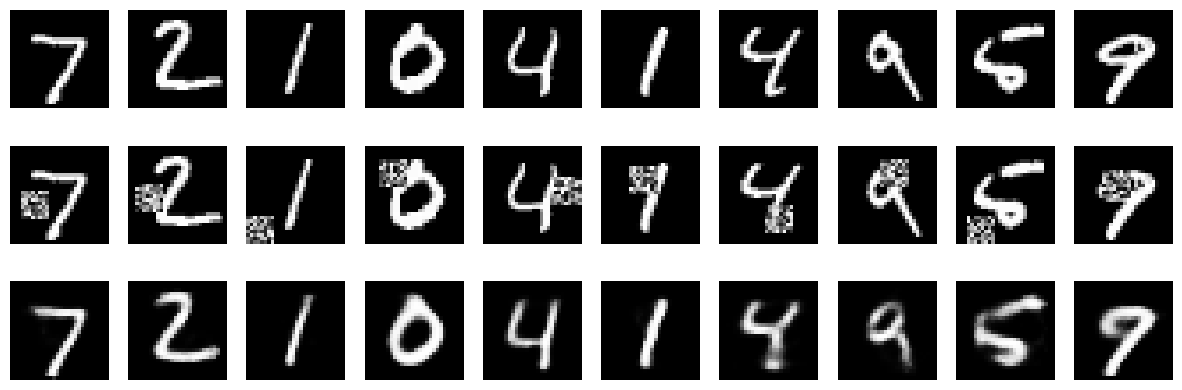

In [ ]:
model.eval()
noisy, clean = next(iter(test_loader))
noisy, clean = noisy.to(device), clean.to(device)
with torch.no_grad():
    denoised = model(noisy)

# Show few examples
noisy = noisy.view(-1, 1, 28, 28).cpu()
clean = clean.view(-1, 1, 28, 28).cpu()
denoised = denoised.view(-1, 1, 28, 28).cpu()

fig, axes = plt.subplots(3, 10, figsize=(15,5))
for i in range(10):
    axes[0,i].imshow(clean[i].squeeze(), cmap="gray"); axes[0,i].axis("off")
    axes[1,i].imshow(noisy[i].squeeze(), cmap="gray"); axes[1,i].axis("off")
    axes[2,i].imshow(denoised[i].squeeze(), cmap="gray"); axes[2,i].axis("off")
axes[0,0].set_ylabel("Original")
axes[1,0].set_ylabel("Noisy")
axes[2,0].set_ylabel("Denoised")
plt.show()